In [ ]:
'''
def norm(signal):
    signal = (signal - norm_lower) / (norm_upper - norm_lower)
    signal = signal[50:]
    return signal

def load_data(path_dir='data/5-2-25/'):
    t, signal = mt.battery(path_dir)
    return norm(signal)

train_data = load_data()[500:1000]
plt.plot(train_data)
train_data = sf(train_data, 30, 3)
plt.plot(train_data)
plt.show()
'''

'''
# Generate synthetic time series data
def load_data(length=200, start=0, end=6, amplitude=0.6, freq=2):
    t = np.linspace(start*np.pi, end*np.pi, length)
    x = amplitude*np.sin(2*t) + np.exp(t/10) + np.random.normal(0, 0.2, size=length)
    return x

# Training data
train_data = load_data(length=200)  # t: [0π, 6π]
train_min, train_max = np.min(train_data), np.max(train_data)
train_data = (train_data - train_min) / (train_max - train_min)

# Test data (non-overlapping, unseen range)
test_data = load_data(length=200, amplitude=2, freq=3)  # t: [6π, 12π]
test_data = (test_data - train_min) / (train_max - train_min)  # Use train's min/max

# Plot the original data
plt.figure(figsize=(10, 5))
plt.plot(train_data, label='Sine Wave')
plt.plot(test_data, label='Sine Wave')
plt.title('Synthetic Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
'''

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import maketab as mt
from scipy.signal import savgol_filter as sf

In [6]:
seq_length = 50
batch_size = 16
hidden_size = 64
norm_upper = 4
norm_lower = 2
num_epochs = 200
num_layers = 1

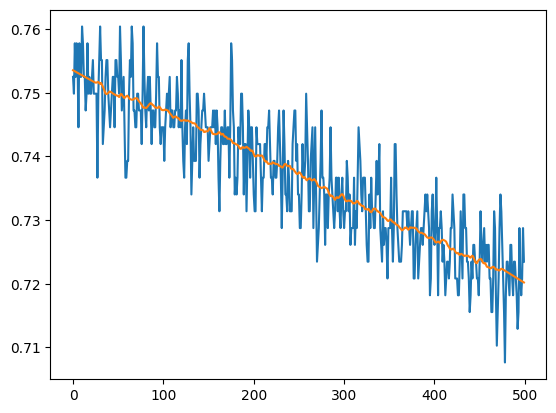

In [7]:
def norm(signal):
    signal = (signal - norm_lower) / (norm_upper - norm_lower)
    signal = signal[50:]
    return signal

def load_data(path_dir='data/5-2-25/'):
    t, signal = mt.battery(path_dir)
    return norm(signal)

train_data = load_data()[500:1000]
plt.plot(train_data)
train_data = sf(train_data, seq_length, 1)
plt.plot(train_data)
plt.show()

In [8]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length
        self.sequences, self.targets = self.create_sequences()
    
    def create_sequences(self):
        sequences, targets = [], []
        for i in range(len(self.data) - self.seq_length):
            sequences.append(self.data[i:i + self.seq_length])
            targets.append(self.data[i + self.seq_length])
        return np.array(sequences), np.array(targets)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)

dataset = TimeSeriesDataset(train_data, seq_length)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

'''
print("Visualizing DataLoader batches:")
for batch_idx, (sequence, target) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"  Sequence shape: {sequence.shape}")  # Shape: [batch_size, seq_length]
    print(f"  Target shape: {target.shape}")      # Shape: [batch_size]
    
    # Print sequences and targets
    for i in range(batch_size):
        print(f"  Sequence {i + 1}: {sequence[i].numpy()}")
        print(f"  Target {i + 1}: {target[i].item():.4f}")
    print("-" * 40)

    # Plot the sequences and targets
    plt.figure(figsize=(10, 5))
    for i in range(batch_size):
        plt.plot(range(batch_idx * batch_size + i, batch_idx * batch_size + i + seq_length), 
                 sequence[i].numpy(), label=f'Sequence {i + 1}', marker='o')
        plt.scatter(batch_idx * batch_size + i + seq_length, target[i].item(), 
                    label=f'Target {i + 1}', marker='x')
    plt.title(f'Batch {batch_idx + 1}: Sequences and Targets')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
'''

'\nprint("Visualizing DataLoader batches:")\nfor batch_idx, (sequence, target) in enumerate(train_loader):\n    print(f"Batch {batch_idx + 1}:")\n    print(f"  Sequence shape: {sequence.shape}")  # Shape: [batch_size, seq_length]\n    print(f"  Target shape: {target.shape}")      # Shape: [batch_size]\n    \n    # Print sequences and targets\n    for i in range(batch_size):\n        print(f"  Sequence {i + 1}: {sequence[i].numpy()}")\n        print(f"  Target {i + 1}: {target[i].item():.4f}")\n    print("-" * 40)\n\n    # Plot the sequences and targets\n    plt.figure(figsize=(10, 5))\n    for i in range(batch_size):\n        plt.plot(range(batch_idx * batch_size + i, batch_idx * batch_size + i + seq_length), \n                 sequence[i].numpy(), label=f\'Sequence {i + 1}\', marker=\'o\')\n        plt.scatter(batch_idx * batch_size + i + seq_length, target[i].item(), \n                    label=f\'Target {i + 1}\', marker=\'x\')\n    plt.title(f\'Batch {batch_idx + 1}: Sequences and 

In [9]:
'''
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        
        # Forward pass through RNN
        out, _ = self.rnn(x, h0)
        
        # Decode the hidden state of the last time step
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        #out = self.fc(out[:, -1, :])
        return out
'''

#'''
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)


    def forward(self, x):      
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # Shape: [num_layers, batch_size, hidden_size]
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # Shape: [num_layers, batch_size, hidden_size]
        
        # Move to the same device as input (if using GPU)
        h0 = h0.to(x.device)
        c0 = c0.to(x.device)
        
        # Forward pass through LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Apply dropout and fully connected layer to the last time step
        out = self.fc(out[:, -1, :])
        return out
#'''

'''
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, kernel_size=3, conv_out_channels=16):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 1D Convolutional layer
        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=conv_out_channels, 
                              kernel_size=kernel_size, padding=(kernel_size-1)//2)
        
        # LSTM layer (input_size is conv_out_channels, not raw input_size)
        self.lstm = nn.LSTM(conv_out_channels, hidden_size, num_layers=num_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: [batch_size, seq_length, input_size] (e.g., [16, 30, 1])
        
        # Reshape for Conv1d: [batch_size, input_size, seq_length] (e.g., [16, 1, 30])
        x = x.transpose(1, 2)
        x = self.conv1d(x)  # [batch_size, conv_out_channels, seq_length] (e.g., [16, 16, 30])
        
        # Reshape back for LSTM: [batch_size, seq_length, conv_out_channels] (e.g., [16, 30, 16])
        x = x.transpose(1, 2)
        
        # LSTM forward pass
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))  # [batch_size, seq_length, hidden_size] (e.g., [16, 30, 200])
        
        # Take the last time step for prediction
        out = self.fc(out[:, -1, :])  # [batch_size, output_size] (e.g., [16, 1])
        return out
'''

# Define model parameters
input_size = 1
output_size = 1  # Predict 1 output at a time during training

# Instantiate the model
model = SimpleRNN(input_size, hidden_size, output_size, num_layers)

# Print the model architecture
print(model)

SimpleRNN(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.97, 0.999))
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.4)  # Halve LR every 50 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=20, threshold=0.0001, min_lr=1e-7)

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_idx, (sequences, targets) in enumerate(train_loader):
        # Reshape sequences to match model input shape
        sequences = sequences.unsqueeze(-1)  # Shape: [batch_size, seq_length, input_size]
        
        # Forward pass
        outputs = model(sequences)  # Shape: [batch_size, output_size]
        
        # Compute loss
        loss = criterion(outputs, targets.unsqueeze(-1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0) #Gradient clipping
        optimizer.step()
        epoch_loss += loss.item()
    #scheduler.step()  # Update learning rate

    #######
    avg_train_loss = epoch_loss / len(train_loader)  # Average loss per batch
    scheduler.step(avg_train_loss)  # Use avg_train_loss for scheduling
    #####


    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Avg Loss: {epoch_loss:.4f}')
        print(f'Avg Train Loss: {avg_train_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.8f}')

print("Training complete.")

Epoch [10/200], Loss: 0.0001, Avg Loss: 0.0019
Avg Train Loss: 0.0001, LR: 0.00100000
Epoch [20/200], Loss: 0.0000, Avg Loss: 0.0014
Avg Train Loss: 0.0000, LR: 0.00100000
Epoch [30/200], Loss: 0.0000, Avg Loss: 0.0014
Avg Train Loss: 0.0000, LR: 0.00100000
Epoch [40/200], Loss: 0.0001, Avg Loss: 0.0014
Avg Train Loss: 0.0000, LR: 0.00100000
Epoch [50/200], Loss: 0.0000, Avg Loss: 0.0014
Avg Train Loss: 0.0000, LR: 0.00100000
Epoch [60/200], Loss: 0.0000, Avg Loss: 0.0014
Avg Train Loss: 0.0000, LR: 0.00100000
Epoch [70/200], Loss: 0.0000, Avg Loss: 0.0013
Avg Train Loss: 0.0000, LR: 0.00100000
Epoch [80/200], Loss: 0.0000, Avg Loss: 0.0013
Avg Train Loss: 0.0000, LR: 0.00100000
Epoch [90/200], Loss: 0.0001, Avg Loss: 0.0014
Avg Train Loss: 0.0000, LR: 0.00100000
Epoch [100/200], Loss: 0.0000, Avg Loss: 0.0014
Avg Train Loss: 0.0000, LR: 0.00100000
Epoch [110/200], Loss: 0.0001, Avg Loss: 0.0014
Avg Train Loss: 0.0000, LR: 0.00100000
Epoch [120/200], Loss: 0.0001, Avg Loss: 0.0013
Avg 

In [11]:
def predict_future(model, initial_sequence, num_predictions):
    """
    Predict future values using the trained model.
    :param model: Trained RNN model.
    :param initial_sequence: Initial input sequence of shape [seq_length].
    :param num_predictions: Number of future values to predict.
    :return: List of predicted values.
    """
    model.eval()
    predictions = []
    current_sequence = initial_sequence.clone()  # Start with the initial sequence
    
    with torch.no_grad():
        for _ in range(num_predictions):
            # Reshape the current sequence to match model input shape
            input_seq = current_sequence.unsqueeze(0).unsqueeze(-1)  # Shape: [1, seq_length, input_size]

            '''    
            Why .unsqueeze(0)?
            The model expects input tensors with a batch dimension. For example, the input shape should be [batch_size, seq_length, input_size]
            current_sequence has shape [seq_length] (e.g., [5] for seq_length=5).
            .unsqueeze(0) adds a batch dimension at the beginning, changing the shape to [1, seq_length] (e.g., [1, 5]).
            Why .unsqueeze(-1)?
            The model also expects an input feature dimension. For example, the input shape should be [batch_size, seq_length, input_size].
            After .unsqueeze(0), the shape is [1, seq_length]. Adding .unsqueeze(-1) adds a feature dimension at the end, changing the shape to [1, seq_length, 1] (e.g., [1, 5, 1]).
            Final Shape:
            The input to the model is now [1, seq_length, 1], which matches the expected input shape.
            '''
            
            # Predict the next value
            next_value = model(input_seq).squeeze().item()

            '''
            model(input_seq):
            Passes the input sequence through the model to get the predicted value.
            The output shape is [1, 1] (batch size of 1, output size of 1).
            .squeeze():
            Removes dimensions of size 1 from the tensor.
            For example, [1, 1] becomes [1].
            .item():
            Extracts the scalar value from a tensor with a single element.
            For example, [0.8660] becomes 0.8660.
            Result:
            next_value is a Python scalar (e.g., 0.8660).
            '''
            predictions.append(next_value)
            
            # Update the current sequence by appending the predicted value and removing oldest value
            #current_sequence = torch.cat((current_sequence[1:], torch.tensor([next_value])))
            current_sequence = torch.cat((current_sequence[1:], torch.tensor([next_value])))
    
    return np.array(predictions)

In [12]:
def plot_predictions(data):
    theta = seq_length*1
    predicted_values = np.empty(0)
    for i in range(seq_length, len(data), theta):
        initial_sequence = data[i-seq_length:i]
        initial_sequence = torch.tensor(initial_sequence, dtype=torch.float32)
        num_predictions = theta
        predicted_values = np.append(predicted_values, predict_future(model, initial_sequence, num_predictions))
        plt.axvline(i)
    return predicted_values
#plt.plot(range(seq_length, seq_length + len(predicted_values)), predicted_values, label='Predicted Data', marker='x', color='tab:orange')

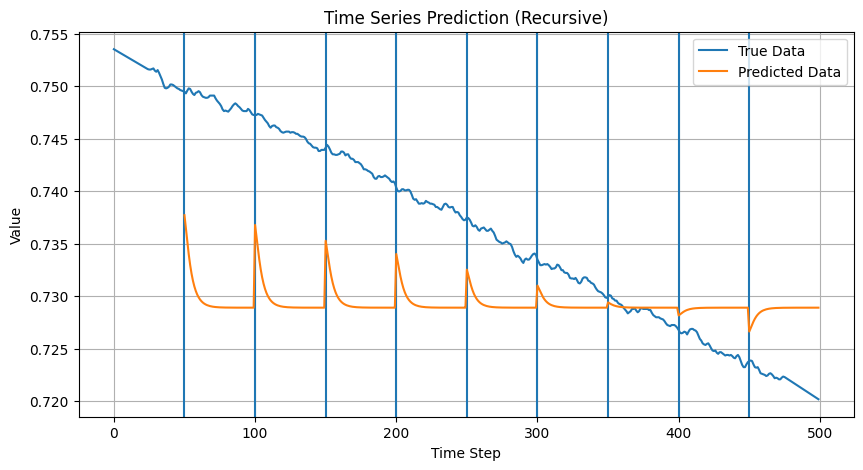

In [13]:
plt.figure(figsize=(10, 5))
data = train_data
predicted_values = plot_predictions(data)
plt.plot(range(len(data)), data, label='True Data', color='tab:blue')
plt.plot(range(seq_length, seq_length + len(predicted_values)), predicted_values, label='Predicted Data', color='tab:orange')
#plot_predictions()
plt.title('Time Series Prediction (Recursive)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()